In [126]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [127]:
c = 3.0e8  # (m/s)
density = 1850  # kg/m³ (SiO2)
kB = 1.380649e-23 # J/K
epsilon_0 = 8.854187817e-12 # (C^2)*(N^-1)*(m^-2)
n_md = 1  # medium refractive index
n_p = 1.46 # particle refractive index
R = 78e-9  # particle radius (m)
T = 297 # K
lamb = 780*1e-9  # (m)
NA = 0.13
P = 200*1e-3 # Total Power (W)
m_gas = 4.81e-26 # molecular mass of air (kg)
Pressure_atm = 1013.25 #mbar (1 atm)
Pressure = (Pressure_atm)/101.325
eta_air = 18.27e-6 # Pa # (J.T.R.Watson (1995)).
d_gas = 0.372e-9 #m #(Sone (2007)), ρSiO2

In [128]:
k = 2*np.pi/lamb
w_0 = 2.5e-6
m_rri = n_p/n_md #relative refractive index
z_R = n_md*w_0/NA #rayleigh range
volume = (4/3) * np.pi * (R**3)
m = density * volume  # kg

In [129]:
def Gamma_env(Pressure_mbar):
    def mfp(P_gas):
        mfp_val = kB*T/(2**0.5*np.pi*d_gas**2*P_gas)
        return mfp_val
    
    Pressure_pascals = 100*Pressure_mbar
    s = mfp(Pressure_pascals)
    K_n = s/R
    c_K = 0.31*K_n/(0.785 + 1.152*K_n + K_n**2)
    gamma = 6*np.pi*eta_air*R/m * 0.619/(0.619 + K_n) * (1+c_K)
    return gamma #Isso está em Hz

def R_curv(z):
    z_safe = np.where(z == 0, 1e-40, z)       #Isso aqui impede que o código quebre em z = 0 substituindo esse
    return z_safe*(1+((z_R**2)/(z_safe**2)))  #ponto por um outro valor muito pequeno diferente de zero.

def gouy_phase(z):
    return np.arctan(z/z_R)

def w(z):
    return w_0*((1+((z**2)/(z_R**2)))**(1/2))

def I(E):
    return c*epsilon_0*(abs(E)**2)/2

In [130]:
dt = 1e-8 #s
N = 1_000_000
t = np.linspace(0, N*dt, N)
gamma_hz = Gamma_env(Pressure) #Hz
D = kB*T/(gamma_hz*m)

In [131]:
z = np.linspace(-30*z_R, 30*z_R, len(t))
x = np.linspace(-5*w_0,5*w_0,len(t))
y = np.linspace(-5*w_0,5*w_0,len(t))

d=50e-6

def E_single(x,y,z):
    E_0 = (np.sqrt(2*P/(np.pi*(w_0**2)*c*epsilon_0)))
    return E_0*(w_0/w(z-d/2))*np.exp((-((x**2)+(y**2)))/(w(z-d/2)**2))*np.exp(-1j*(k*(z-d/2)+k*(((x**2)+(y**2))/(2*R_curv(z-d/2))) - gouy_phase(z-d/2)))

def E(x,y,z):
    E_01 = (np.sqrt(P/(np.pi*(w_0**2)*c*epsilon_0)))
    E_02 = (np.sqrt(P/(np.pi*(w_0**2)*c*epsilon_0)))
    E1 = E_01*(w_0/w(z-d/2))*np.exp((-((x**2)+(y**2)))/(w(z-d/2)**2))*np.exp(-1j*(k*(z-d/2)+k*(((x**2)+(y**2))/(2*R_curv(z-d/2))) - gouy_phase(z-d/2)))
    E2 = E_02*(w_0/w(z+d/2))*np.exp((-((x**2)+(y**2)))/(w(z+d/2)**2))*np.exp(1j*(k*(z+d/2)+k*(((x**2)+(y**2))/(2*R_curv(z+d/2))) - gouy_phase(z+d/2)))
    return E1 + E2

def I(E):
    return c*epsilon_0*(abs(E)**2)/2

I_z = I(E(0,0,z))
I_single_z = I(E_single(0,0,z))
I_x = I(E(x,0,0))
I_y = I(E(0,y,0))

F_scatt_z = ((128*(np.pi**5)*(n_md**5)*(R**6))/(3*c*(lamb**4)))*((((m_rri**2)-1)/((m_rri**2) + 2))**2)*I_z

F_grad_z = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))*np.gradient(I_z, z)
F_grad_x = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))*np.gradient(I_x, x)
F_grad_y = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))*np.gradient(I_y, y)

F_grad_single_z = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))*np.gradient(I_single_z, z)
F_scatt_single_z = ((128*(np.pi**5)*(n_md**5)*(R**6))/(3*c*(lamb**4)))*((((m_rri**2)-1)/((m_rri**2) + 2))**2)*I_single_z

F_total_single_z = F_grad_single_z + F_scatt_single_z
F_total_z = F_grad_z + F_scatt_z

@njit(fastmath=True)
def dx_dt(v):
    return v

@njit(fastmath=True)
def dv_dt(v, F, gamma_hz, m):
    return (F/m) - gamma_hz*v

In [132]:
#plt.plot(z, F_grad_z, label="Original F_grad_z")
#z_test = np.linspace(-3*z_R, 3*z_R, 10*len(z))  # Criar mais pontos para visualização
#F_interp = np.interp(z_test, z, F_grad_z)
#plt.plot(z_test, F_interp, label="Interpolated", linestyle="--")
#plt.legend()
#plt.show()

In [133]:
@njit(fastmath=True)
def runge_kutta(t, v_init, pos_init, dt):
    positions = np.zeros((len(t), 3))
    velocities = np.zeros((len(t), 3))
    
    positions[0] = pos_init
    velocities[0] = v_init

    for i in range(len(t) - 1):
        if (i > len(t)*0.2 and i <len(t)*0.205) or (i > len(t)*0.4 and i <len(t)*0.405) or (i > len(t)*0.6 and i <len(t)*0.605) or (i > len(t)*0.8 and i <len(t)*0.805):
            F = [(np.interp(positions[i,0], x, F_grad_x)),(np.interp(positions[i,1], y, F_grad_y)), (np.interp(positions[i,2], z, F_total_single_z))]
        else:
            F = [(np.interp(positions[i,0], x, F_grad_x)),(np.interp(positions[i,1], y, F_grad_y)), (np.interp(positions[i,2], z, F_total_z))]
        
        for dim in range(3):
            k1_pos = velocities[i,dim] * dt
            k1_v = dv_dt(velocities[i,dim], F[dim], gamma_hz, m) * dt

            k2_pos = (velocities[i,dim] + 0.5 * k1_v) * dt
            k2_v = dv_dt(velocities[i,dim] + 0.5 * k1_v, F[dim], gamma_hz, m) * dt

            k3_pos = (velocities[i,dim] + 0.5 * k2_v) * dt
            k3_v = dv_dt(velocities[i,dim] + 0.5 * k2_v, F[dim], gamma_hz, m) * dt

            k4_pos = (velocities[i,dim] + k3_v) * dt
            k4_v = dv_dt(velocities[i,dim] + k3_v, F[dim], gamma_hz, m) * dt

            positions[i + 1,dim] = positions[i,dim] + (1 / 6) * (k1_pos + 2 * k2_pos + 2 * k3_pos + k4_pos)
            velocities[i + 1,dim] = velocities[i,dim] + (1 / 6) * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)

            thermal_noise = np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal() * np.sqrt(dt) / m
            velocities[i + 1,dim] += thermal_noise
        
    return positions, velocities

In [134]:
1/(dt*len(t)*0.05)

2000.0

In [135]:
velInit = (0,0,0)
posInit = (0,0,0)

pos, v_z = runge_kutta(t, velInit, posInit, dt)

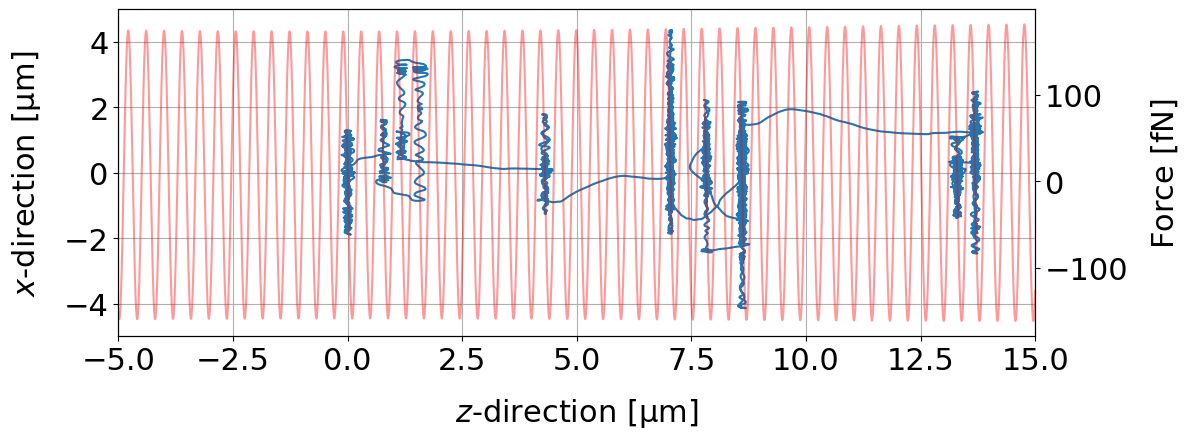

In [136]:
#from matplotlib.patches import Circle
#x_0, y_0 = 0, 0  # Ponto central do círculo
#r = 75e-3  # Raio do círculo


#fig, ax1 = plt.subplots(figsize=(6.2,4.5))
fig, ax1 = plt.subplots(figsize=(12,4.5))

ax1.plot(pos[:,2]*1e6, pos[:,0]*1e6)
ax1.set_xlabel(r'$z \text{-direction}\ \mathrm{[\mu m]}$', fontsize=22, labelpad=15)
ax1.set_ylabel(r'$x \text{-direction}\ \mathrm{[\mu m]}$',fontsize=22, labelpad=15)
ax1.grid(True)
ax1.set_xlim(-5,15)
ax1.set_ylim(-5,5)

#circle = Circle((x_0, y_0), r, color='blue', fill=False)  # O círculo é azul e não preenchido
#ax1.add_patch(circle)

ax2 = ax1.twinx()
ax2.plot(z*1e6, (F_total_z*1e15), color='r', alpha = 0.4)
ax2.set_ylabel(r'$\text{Force}\ \mathrm{[fN]}$',fontsize=22, labelpad=15)

#if parametro == 0:
#    ax2.set_ylim(-100,100)
#else:
#    ax2.set_ylim(-1800,1800)

ax1.tick_params(axis='x', labelsize=22)
ax1.tick_params(axis='y', labelsize=22)
ax2.tick_params(axis='y', labelsize=22)

#plt.gca().set_aspect('equal', adjustable='b')
plt.tight_layout()
#plt.savefig("trajectories_conveyor_4jumps_2.pdf", format='pdf', dpi=3000)

plt.show()